# 02-1 Feature 분석: 파생변수별 voting rate 차이
- 02_first_test.ipynb에서 만든 파생변수를 기준으로 **voting rate 차이**를 확인
- 수치형은 구간화(quantile bin), 범주형은 그룹별 평균 투표율 비교


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


## 1. 데이터 로드


In [ ]:
train = pd.read_csv("../../data/raw/train.csv")

## 2. 02_first_test와 동일한 파이프라인으로 파생변수 생성


In [3]:
from sklearn.preprocessing import LabelEncoder

# -----------------------------
# 공통 전처리/피처 생성 함수
# -----------------------------
def build_features(df_raw, cfg=None, is_train=True):
    df = df_raw.copy()

    # 0) voted -> voted_bin (train에만 존재)
    if is_train and "voted" in df.columns:
        df["voted_bin"] = (df["voted"] == 2).astype(int)

    # 1) age_group -> ordinal
    if "age_group" in df.columns:
        age_map = {"10s":1, "20s":2, "30s":3, "40s":4, "50s":5, "60s":6, "+70s":7}
        df["age_group_ord"] = df["age_group"].map(age_map).astype("float32")

    # 2) education (0=무응답 -> NaN -> train 평균으로 대치)
    if "education" in df.columns:
        df["education"] = pd.to_numeric(df["education"], errors="coerce")
        df.loc[df["education"] == 0, "education"] = np.nan
        if cfg is not None:
            df["education"] = df["education"].fillna(cfg["education_mean"])
        df["education"] = df["education"].astype("float32")

    # 3) married_bin (1=미혼 vs 기타, 0=무응답 NaN)
    if "married" in df.columns:
        df["married"] = pd.to_numeric(df["married"], errors="coerce")
        df.loc[df["married"] == 0, "married"] = np.nan
        df["married_bin"] = (df["married"] == 1).astype("float32")

    # 4) hand_bin (3=양손 vs 기타, 0=무응답 NaN)
    if "hand" in df.columns:
        df["hand"] = pd.to_numeric(df["hand"], errors="coerce")
        df.loc[df["hand"] == 0, "hand"] = np.nan
        df["hand_bin"] = (df["hand"] == 3).astype("float32")

    # 5) urban_ord (0=무응답 NaN)
    if "urban" in df.columns:
        df["urban"] = pd.to_numeric(df["urban"], errors="coerce")
        df.loc[df["urban"] == 0, "urban"] = np.nan
        df["urban_ord"] = df["urban"].astype("float32")

    # 6) race/religion 단순화: train에서 뽑은 top-k만 살리고 나머지 Other
    def simplify_major_other(series, majors):
        return series.apply(lambda x: x if x in majors else "Other")

    if "race" in df.columns and cfg is not None:
        df["race_simple"] = simplify_major_other(df["race"], cfg["race_majors"]).astype(str)

    if "religion" in df.columns and cfg is not None:
        df["religion_simple"] = simplify_major_other(df["religion"], cfg["religion_majors"]).astype(str)

    # 7) Q_A: neg_att / pos_att / confident_ratio / neutral_ratio
    neg_cols = ["QbA","QcA","QjA","QmA","QoA","QsA"]
    pos_cols = ["QkA","QqA"]
    other_cols = ["QeA","QfA","QhA","QrA"]

    for col in neg_cols + pos_cols + other_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    if all(c in df.columns for c in neg_cols):
        df["neg_att"] = df[neg_cols].mean(axis=1)

    if all(c in df.columns for c in pos_cols):
        df["pos_att"] = df[pos_cols].mean(axis=1)

    if all(c in df.columns for c in other_cols):
        other = df[other_cols]
        df["neutral_ratio"] = (other == 3).mean(axis=1).astype("float32")
        df["confident_ratio"] = ((other <= 2) | (other >= 4)).mean(axis=1).astype("float32")

    # 8) TP Big5 diff/strength
    tp_pairs = {
        "extraversion": ("tp01", "tp06"),
        "agreeableness": ("tp07", "tp02"),
        "conscientiousness": ("tp03", "tp08"),
        "neuroticism": ("tp04", "tp09"),
        "openness": ("tp05", "tp10"),
    }
    for trait, (a, b) in tp_pairs.items():
        if a in df.columns and b in df.columns:
            df[a] = pd.to_numeric(df[a], errors="coerce")
            df[b] = pd.to_numeric(df[b], errors="coerce")
            df[f"{trait}_diff"] = (df[a] - df[b]).astype("float32")
            df[f"{trait}_strength"] = df[f"{trait}_diff"].abs().astype("float32")

    # 9) 단어 인지: wr_sum / wf_sum / word_credibility
    wr_cols = [f"wr_{i:02d}" for i in range(1, 14)]
    wf_cols = [f"wf_{i:02d}" for i in range(1, 4)]

    if all(c in df.columns for c in wr_cols):
        df["wr_sum"] = df[wr_cols].sum(axis=1).astype("float32")

    if all(c in df.columns for c in wf_cols):
        df["wf_sum"] = df[wf_cols].sum(axis=1).astype("float32")

    if "wr_sum" in df.columns and "wf_sum" in df.columns:
        df["word_credibility"] = (df["wr_sum"] - df["wf_sum"]).astype("float32")

    # 9-1) 단어 인지 구간화 (EDA 기준)
    if "word_credibility" in df.columns:
        df["cred_bin"] = pd.cut(
            df["word_credibility"],
            bins=[-3, 1, 6, 13],
            labels=["Low", "Mid", "High"]
        )

    return df

# cfg 생성
cfg = {}
edu = pd.to_numeric(train["education"], errors="coerce").replace(0, np.nan)
cfg["education_mean"] = float(edu.mean())

cfg["race_majors"] = set(train["race"].value_counts(dropna=True).head(5).index)
cfg["religion_majors"] = set(train["religion"].value_counts(dropna=True).head(5).index)

# 적용
df_feat = build_features(train, cfg=cfg, is_train=True)


## 3. voting rate 요약 함수


In [4]:
def summarize_numeric(df, col, bins=5):
    s = df[[col, "voted_bin"]].copy()
    s = s.dropna()
    # 값 종류가 적으면 범주형처럼 처리
    if s[col].nunique() <= 5:
        out = s.groupby(col)["voted_bin"].agg(["mean", "count"]).reset_index()
        out = out.rename(columns={col: "bin"})
        return out
    s["bin"] = pd.qcut(s[col], q=bins, duplicates="drop")
    out = s.groupby("bin")["voted_bin"].agg(["mean", "count"]).reset_index()
    return out

def summarize_categorical(df, col):
    s = df[[col, "voted_bin"]].copy()
    out = s.groupby(col)["voted_bin"].agg(["mean", "count"]).reset_index()
    return out.sort_values("count", ascending=False)


## 4. 주요 파생변수별 voting rate


In [7]:
numeric_features = [
    "neg_att", "pos_att", "neutral_ratio", "confident_ratio",
    "extraversion_diff", "extraversion_strength",
    "agreeableness_diff", "agreeableness_strength",
    "conscientiousness_diff", "conscientiousness_strength",
    "neuroticism_diff", "neuroticism_strength",
    "openness_diff", "openness_strength",
    "wr_sum", "wf_sum", "word_credibility",
    "age_group_ord", "education", "urban_ord",
    "hand_bin", "married_bin",
]

cat_features = ["race_simple", "religion_simple", "cred_bin"]

# 수치형 요약
for col in numeric_features:
    if col in df_feat.columns:
        print("Numeric]", col)
        display(summarize_numeric(df_feat, col, bins=5))

# 범주형 요약
for col in cat_features:
    if col in df_feat.columns:
        print("[Categorical]", col)
        display(summarize_categorical(df_feat, col))


Numeric] neg_att


/var/folders/zb/7vcy0_ts23q_3pjlgfdd_cl80000gn/T/ipykernel_73785/2783759410.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = s.groupby("bin")["voted_bin"].agg(["mean", "count"]).reset_index()


,bin,mean,count
0,"(0.999, 2.5]",0.468870,10408
1,"(2.5, 3.167]",0.529127,8892
2,"(3.167, 3.767]",0.553934,8019
3,"(3.767, 4.333]",0.579614,10821
4,"(4.333, 5.0]",0.622159,7392


Numeric] pos_att


/var/folders/zb/7vcy0_ts23q_3pjlgfdd_cl80000gn/T/ipykernel_73785/2783759410.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = s.groupby("bin")["voted_bin"].agg(["mean", "count"]).reset_index()


,bin,mean,count
0,"(0.999, 2.0]",0.632210,9171
1,"(2.0, 3.0]",0.585988,11676
2,"(3.0, 4.0]",0.534624,12549
3,"(4.0, 4.5]",0.468592,6718
4,"(4.5, 5.0]",0.443152,5418


Numeric] neutral_ratio


/var/folders/zb/7vcy0_ts23q_3pjlgfdd_cl80000gn/T/ipykernel_73785/2783759410.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = s.groupby("bin")["voted_bin"].agg(["mean", "count"]).reset_index()


,bin,mean,count
0,"(-0.001, 0.25]",0.538925,40861
1,"(0.25, 1.0]",0.615928,4671


Numeric] confident_ratio


/var/folders/zb/7vcy0_ts23q_3pjlgfdd_cl80000gn/T/ipykernel_73785/2783759410.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = s.groupby("bin")["voted_bin"].agg(["mean", "count"]).reset_index()


,bin,mean,count
0,"(-0.001, 0.75]",0.577025,18559
1,"(0.75, 1.0]",0.526045,26973


Numeric] extraversion_diff


/var/folders/zb/7vcy0_ts23q_3pjlgfdd_cl80000gn/T/ipykernel_73785/2783759410.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = s.groupby("bin")["voted_bin"].agg(["mean", "count"]).reset_index()


,bin,mean,count
0,"(-7.001, -3.0]",0.506773,10557
1,"(-3.0, 0.0]",0.544203,11764
2,"(0.0, 2.0]",0.559080,7566
3,"(2.0, 4.0]",0.564529,8469
4,"(4.0, 7.0]",0.576226,7176


Numeric] extraversion_strength


/var/folders/zb/7vcy0_ts23q_3pjlgfdd_cl80000gn/T/ipykernel_73785/2783759410.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = s.groupby("bin")["voted_bin"].agg(["mean", "count"]).reset_index()


,bin,mean,count
0,"(-0.001, 1.0]",0.555022,12504
1,"(1.0, 2.0]",0.540873,6826
2,"(2.0, 4.0]",0.545505,14361
3,"(4.0, 5.0]",0.542917,6163
4,"(5.0, 7.0]",0.543501,5678


Numeric] agreeableness_diff


/var/folders/zb/7vcy0_ts23q_3pjlgfdd_cl80000gn/T/ipykernel_73785/2783759410.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = s.groupby("bin")["voted_bin"].agg(["mean", "count"]).reset_index()


,bin,mean,count
0,"(-7.001, -3.0]",0.490196,11883
1,"(-3.0, -1.0]",0.542917,11033
2,"(-1.0, 0.0]",0.548513,7194
3,"(0.0, 2.0]",0.571632,8425
4,"(2.0, 7.0]",0.617550,6997


Numeric] agreeableness_strength


/var/folders/zb/7vcy0_ts23q_3pjlgfdd_cl80000gn/T/ipykernel_73785/2783759410.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = s.groupby("bin")["voted_bin"].agg(["mean", "count"]).reset_index()


,bin,mean,count
0,"(-0.001, 1.0]",0.551066,18339
1,"(1.0, 3.0]",0.558623,14346
2,"(3.0, 4.0]",0.541957,5589
3,"(4.0, 7.0]",0.516533,7258


Numeric] conscientiousness_diff


/var/folders/zb/7vcy0_ts23q_3pjlgfdd_cl80000gn/T/ipykernel_73785/2783759410.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = s.groupby("bin")["voted_bin"].agg(["mean", "count"]).reset_index()


,bin,mean,count
0,"(-7.001, -5.0]",0.463422,10334
1,"(-5.0, -3.0]",0.528618,9784
2,"(-3.0, -1.0]",0.557206,9693
3,"(-1.0, 1.0]",0.592861,8545
4,"(1.0, 7.0]",0.622910,7176


Numeric] conscientiousness_strength


/var/folders/zb/7vcy0_ts23q_3pjlgfdd_cl80000gn/T/ipykernel_73785/2783759410.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = s.groupby("bin")["voted_bin"].agg(["mean", "count"]).reset_index()


,bin,mean,count
0,"(-0.001, 1.0]",0.582839,13647
1,"(1.0, 2.0]",0.568973,7155
2,"(2.0, 4.0]",0.551817,13017
3,"(4.0, 5.0]",0.501634,5815
4,"(5.0, 7.0]",0.470159,5898


Numeric] neuroticism_diff


/var/folders/zb/7vcy0_ts23q_3pjlgfdd_cl80000gn/T/ipykernel_73785/2783759410.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = s.groupby("bin")["voted_bin"].agg(["mean", "count"]).reset_index()


,bin,mean,count
0,"(-7.001, -2.0]",0.600396,12625
1,"(-2.0, 0.0]",0.555775,9126
2,"(0.0, 2.0]",0.537619,8121
3,"(2.0, 4.0]",0.512400,7863
4,"(4.0, 7.0]",0.493908,7797


Numeric] neuroticism_strength


/var/folders/zb/7vcy0_ts23q_3pjlgfdd_cl80000gn/T/ipykernel_73785/2783759410.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = s.groupby("bin")["voted_bin"].agg(["mean", "count"]).reset_index()


,bin,mean,count
0,"(-0.001, 1.0]",0.546385,13485
1,"(1.0, 2.0]",0.554804,7536
2,"(2.0, 3.0]",0.553800,6645
3,"(3.0, 5.0]",0.543318,12466
4,"(5.0, 7.0]",0.536296,5400


Numeric] openness_diff


/var/folders/zb/7vcy0_ts23q_3pjlgfdd_cl80000gn/T/ipykernel_73785/2783759410.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = s.groupby("bin")["voted_bin"].agg(["mean", "count"]).reset_index()


,bin,mean,count
0,"(-7.001, -5.0]",0.523494,14940
1,"(-5.0, -4.0]",0.542442,7575
2,"(-4.0, -3.0]",0.558311,5968
3,"(-3.0, -1.0]",0.558500,9094
4,"(-1.0, 7.0]",0.572847,7955


Numeric] openness_strength


/var/folders/zb/7vcy0_ts23q_3pjlgfdd_cl80000gn/T/ipykernel_73785/2783759410.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = s.groupby("bin")["voted_bin"].agg(["mean", "count"]).reset_index()


,bin,mean,count
0,"(-0.001, 1.0]",0.568247,9700
1,"(1.0, 3.0]",0.558786,12656
2,"(3.0, 4.0]",0.545055,7968
3,"(4.0, 5.0]",0.526818,7439
4,"(5.0, 7.0]",0.521560,7769


Numeric] wr_sum


/var/folders/zb/7vcy0_ts23q_3pjlgfdd_cl80000gn/T/ipykernel_73785/2783759410.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = s.groupby("bin")["voted_bin"].agg(["mean", "count"]).reset_index()


,bin,mean,count
0,"(-0.001, 8.0]",0.646216,12779
1,"(8.0, 9.0]",0.573464,10597
2,"(9.0, 10.0]",0.525281,8999
3,"(10.0, 11.0]",0.469417,6180
4,"(11.0, 13.0]",0.420668,6977


Numeric] wf_sum


/var/folders/zb/7vcy0_ts23q_3pjlgfdd_cl80000gn/T/ipykernel_73785/2783759410.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = s.groupby("bin")["voted_bin"].agg(["mean", "count"]).reset_index()


,bin,mean,count
0,"(-0.001, 1.0]",0.548671,42027
1,"(1.0, 3.0]",0.524679,3505


Numeric] word_credibility


/var/folders/zb/7vcy0_ts23q_3pjlgfdd_cl80000gn/T/ipykernel_73785/2783759410.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = s.groupby("bin")["voted_bin"].agg(["mean", "count"]).reset_index()


,bin,mean,count
0,"(-3.001, 8.0]",0.631933,15739
1,"(8.0, 9.0]",0.558751,11370
2,"(9.0, 10.0]",0.505652,8846
3,"(10.0, 11.0]",0.454978,5042
4,"(11.0, 13.0]",0.403969,4535


Numeric] age_group_ord


/var/folders/zb/7vcy0_ts23q_3pjlgfdd_cl80000gn/T/ipykernel_73785/2783759410.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = s.groupby("bin")["voted_bin"].agg(["mean", "count"]).reset_index()


,bin,mean,count
0,"(0.999, 2.0]",0.654111,28327
1,"(2.0, 4.0]",0.390316,12887
2,"(4.0, 7.0]",0.310097,4318


Numeric] education


/var/folders/zb/7vcy0_ts23q_3pjlgfdd_cl80000gn/T/ipykernel_73785/2783759410.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = s.groupby("bin")["voted_bin"].agg(["mean", "count"]).reset_index()


,bin,mean,count
0,"(0.999, 2.0]",0.706609,21923
1,"(2.0, 3.0]",0.407490,15755
2,"(3.0, 4.0]",0.380316,7854


Numeric] urban_ord


/var/folders/zb/7vcy0_ts23q_3pjlgfdd_cl80000gn/T/ipykernel_73785/2783759410.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = s.groupby("bin")["voted_bin"].agg(["mean", "count"]).reset_index()


,bin,mean,count
0,"(0.999, 2.0]",0.525744,27443
1,"(2.0, 3.0]",0.580402,17767


Numeric] hand_bin


/var/folders/zb/7vcy0_ts23q_3pjlgfdd_cl80000gn/T/ipykernel_73785/2783759410.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = s.groupby("bin")["voted_bin"].agg(["mean", "count"]).reset_index()


,bin,mean,count
0,"(-0.001, 1.0]",0.546824,45532


Numeric] married_bin


/var/folders/zb/7vcy0_ts23q_3pjlgfdd_cl80000gn/T/ipykernel_73785/2783759410.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = s.groupby("bin")["voted_bin"].agg(["mean", "count"]).reset_index()


,bin,mean,count
0,"(-0.001, 1.0]",0.546824,45532


[Categorical] race_simple


,race_simple,mean,count
4,White,0.495776,31248
0,Asian,0.704565,6834
3,Other,0.628010,4734
1,Black,0.597786,2168
2,Native American,0.587591,548


[Categorical] religion_simple


,religion_simple,mean,count
1,Atheist,0.572704,10192
0,Agnostic,0.542602,9624
5,Other,0.599806,9273
2,Christian_Catholic,0.526512,6431
3,Christian_Other,0.539615,5137
4,Christian_Protestant,0.434667,4875


[Categorical] cred_bin


/var/folders/zb/7vcy0_ts23q_3pjlgfdd_cl80000gn/T/ipykernel_73785/2783759410.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = s.groupby(col)["voted_bin"].agg(["mean", "count"]).reset_index()


,cred_bin,mean,count
2,High,0.532635,40769
1,Mid,0.675776,4025
0,Low,0.626027,730


## 5. 시각화 (voting rate 비교)
- 수치형: 구간별 평균 투표율 barplot
- 범주형: 카테고리별 평균 투표율 barplot


/var/folders/zb/7vcy0_ts23q_3pjlgfdd_cl80000gn/T/ipykernel_73785/2783759410.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = s.groupby("bin")["voted_bin"].agg(["mean", "count"]).reset_index()


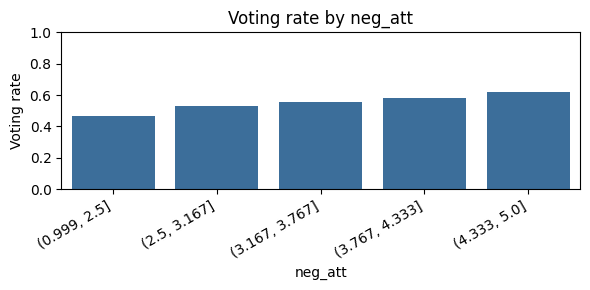

/var/folders/zb/7vcy0_ts23q_3pjlgfdd_cl80000gn/T/ipykernel_73785/2783759410.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = s.groupby("bin")["voted_bin"].agg(["mean", "count"]).reset_index()


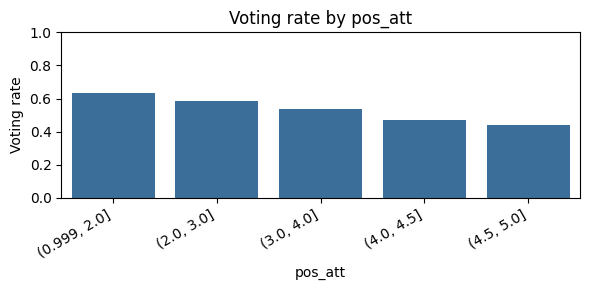

/var/folders/zb/7vcy0_ts23q_3pjlgfdd_cl80000gn/T/ipykernel_73785/2783759410.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = s.groupby("bin")["voted_bin"].agg(["mean", "count"]).reset_index()


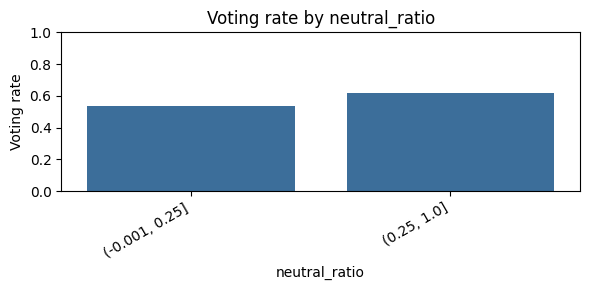

/var/folders/zb/7vcy0_ts23q_3pjlgfdd_cl80000gn/T/ipykernel_73785/2783759410.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = s.groupby("bin")["voted_bin"].agg(["mean", "count"]).reset_index()


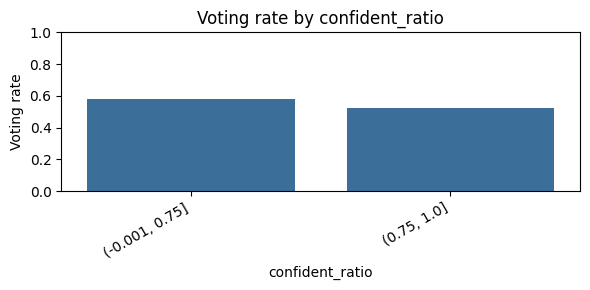

/var/folders/zb/7vcy0_ts23q_3pjlgfdd_cl80000gn/T/ipykernel_73785/2783759410.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = s.groupby("bin")["voted_bin"].agg(["mean", "count"]).reset_index()


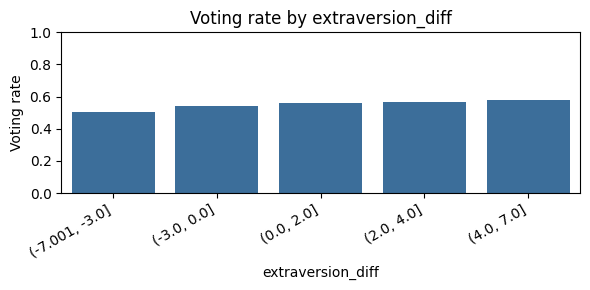

/var/folders/zb/7vcy0_ts23q_3pjlgfdd_cl80000gn/T/ipykernel_73785/2783759410.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = s.groupby("bin")["voted_bin"].agg(["mean", "count"]).reset_index()


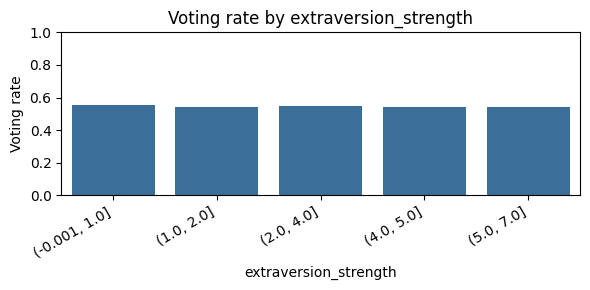

/var/folders/zb/7vcy0_ts23q_3pjlgfdd_cl80000gn/T/ipykernel_73785/2783759410.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = s.groupby("bin")["voted_bin"].agg(["mean", "count"]).reset_index()


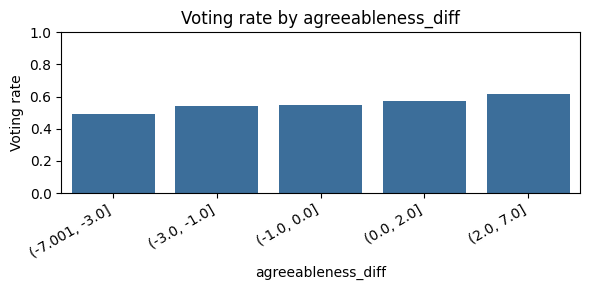

/var/folders/zb/7vcy0_ts23q_3pjlgfdd_cl80000gn/T/ipykernel_73785/2783759410.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = s.groupby("bin")["voted_bin"].agg(["mean", "count"]).reset_index()


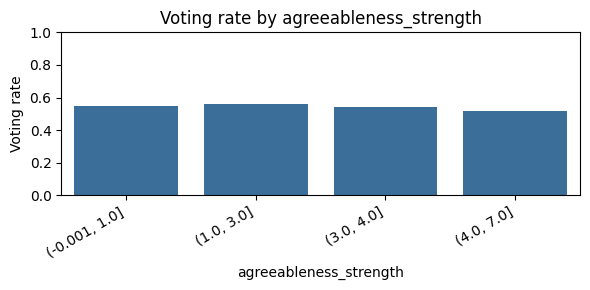

/var/folders/zb/7vcy0_ts23q_3pjlgfdd_cl80000gn/T/ipykernel_73785/2783759410.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = s.groupby("bin")["voted_bin"].agg(["mean", "count"]).reset_index()


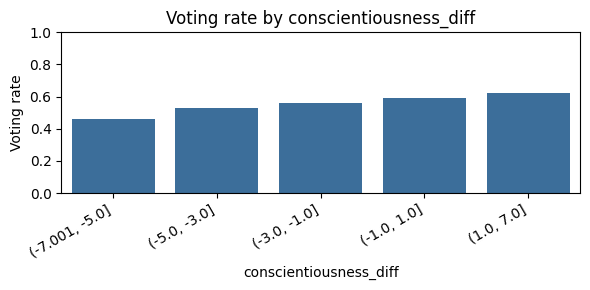

/var/folders/zb/7vcy0_ts23q_3pjlgfdd_cl80000gn/T/ipykernel_73785/2783759410.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = s.groupby("bin")["voted_bin"].agg(["mean", "count"]).reset_index()


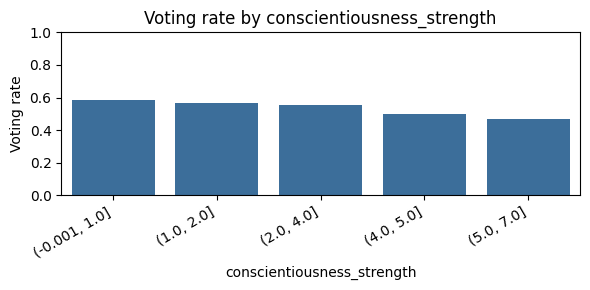

/var/folders/zb/7vcy0_ts23q_3pjlgfdd_cl80000gn/T/ipykernel_73785/2783759410.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = s.groupby("bin")["voted_bin"].agg(["mean", "count"]).reset_index()


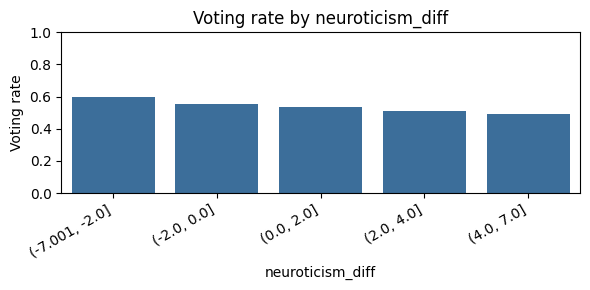

/var/folders/zb/7vcy0_ts23q_3pjlgfdd_cl80000gn/T/ipykernel_73785/2783759410.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = s.groupby("bin")["voted_bin"].agg(["mean", "count"]).reset_index()


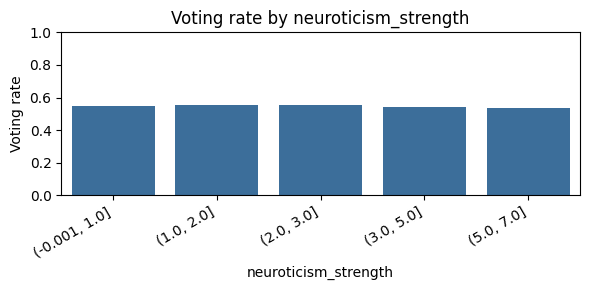

/var/folders/zb/7vcy0_ts23q_3pjlgfdd_cl80000gn/T/ipykernel_73785/2783759410.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = s.groupby("bin")["voted_bin"].agg(["mean", "count"]).reset_index()


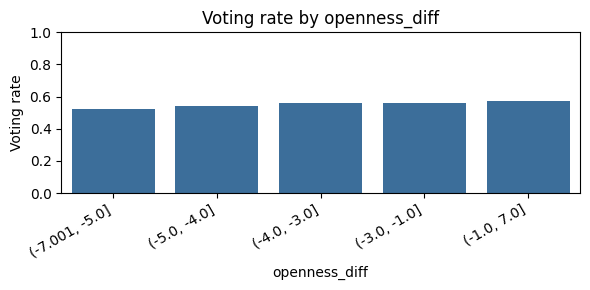

/var/folders/zb/7vcy0_ts23q_3pjlgfdd_cl80000gn/T/ipykernel_73785/2783759410.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = s.groupby("bin")["voted_bin"].agg(["mean", "count"]).reset_index()


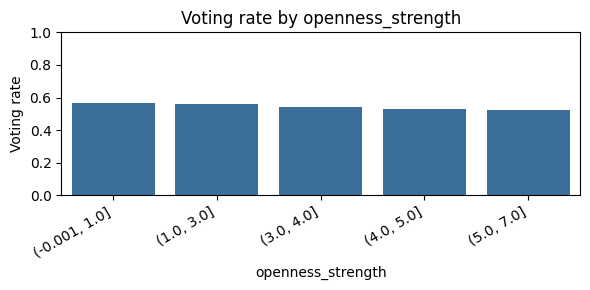

/var/folders/zb/7vcy0_ts23q_3pjlgfdd_cl80000gn/T/ipykernel_73785/2783759410.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = s.groupby("bin")["voted_bin"].agg(["mean", "count"]).reset_index()


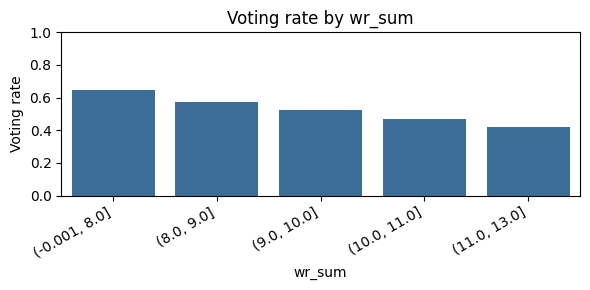

/var/folders/zb/7vcy0_ts23q_3pjlgfdd_cl80000gn/T/ipykernel_73785/2783759410.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = s.groupby("bin")["voted_bin"].agg(["mean", "count"]).reset_index()


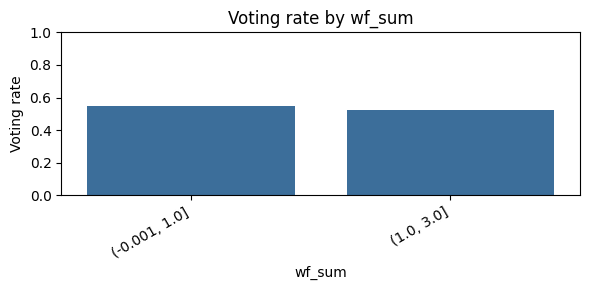

/var/folders/zb/7vcy0_ts23q_3pjlgfdd_cl80000gn/T/ipykernel_73785/2783759410.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = s.groupby("bin")["voted_bin"].agg(["mean", "count"]).reset_index()


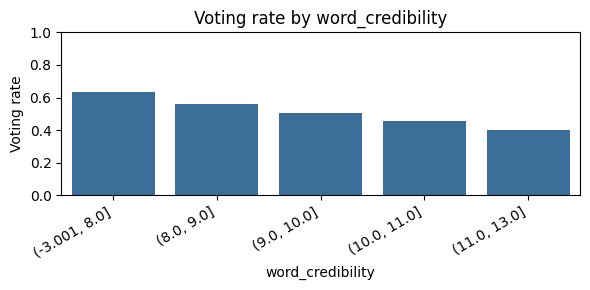

/var/folders/zb/7vcy0_ts23q_3pjlgfdd_cl80000gn/T/ipykernel_73785/2783759410.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = s.groupby("bin")["voted_bin"].agg(["mean", "count"]).reset_index()


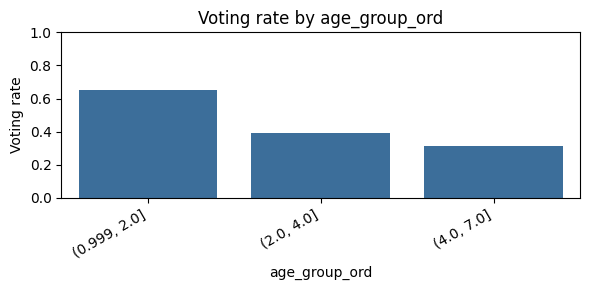

/var/folders/zb/7vcy0_ts23q_3pjlgfdd_cl80000gn/T/ipykernel_73785/2783759410.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = s.groupby("bin")["voted_bin"].agg(["mean", "count"]).reset_index()


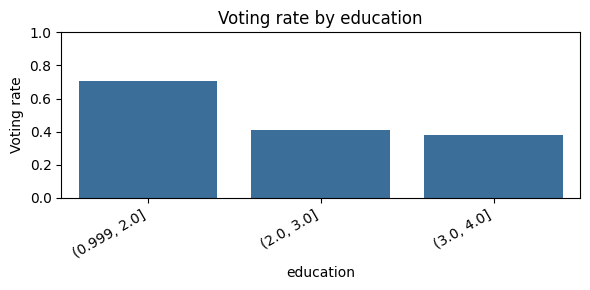

/var/folders/zb/7vcy0_ts23q_3pjlgfdd_cl80000gn/T/ipykernel_73785/2783759410.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = s.groupby("bin")["voted_bin"].agg(["mean", "count"]).reset_index()


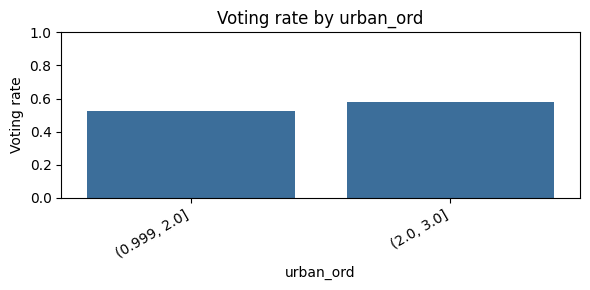

/var/folders/zb/7vcy0_ts23q_3pjlgfdd_cl80000gn/T/ipykernel_73785/2783759410.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = s.groupby("bin")["voted_bin"].agg(["mean", "count"]).reset_index()


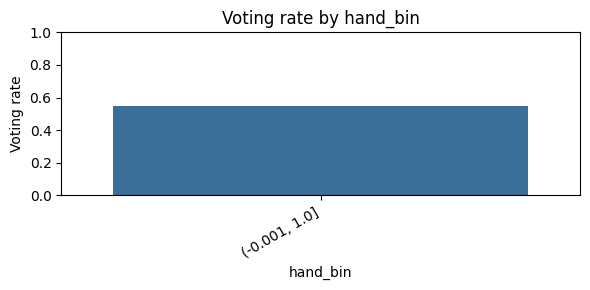

/var/folders/zb/7vcy0_ts23q_3pjlgfdd_cl80000gn/T/ipykernel_73785/2783759410.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = s.groupby("bin")["voted_bin"].agg(["mean", "count"]).reset_index()


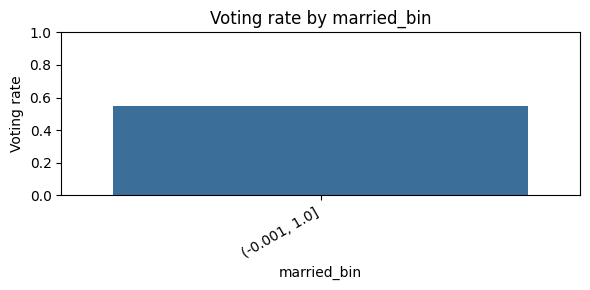

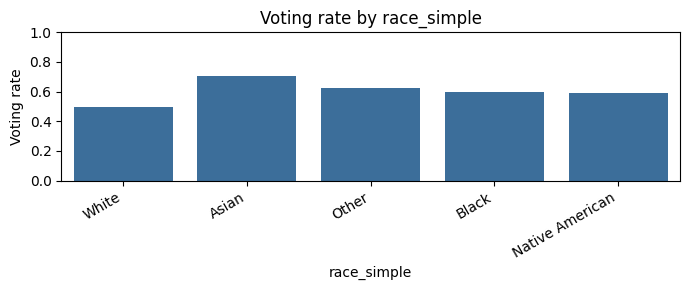

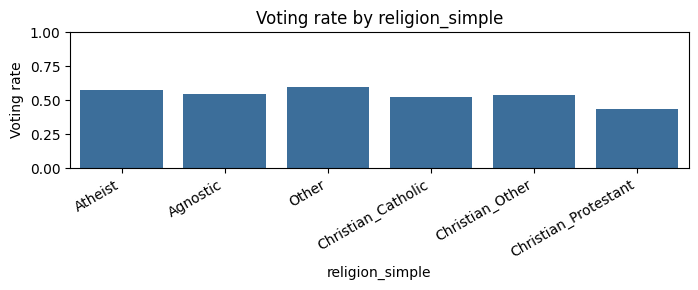

/var/folders/zb/7vcy0_ts23q_3pjlgfdd_cl80000gn/T/ipykernel_73785/2783759410.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = s.groupby(col)["voted_bin"].agg(["mean", "count"]).reset_index()


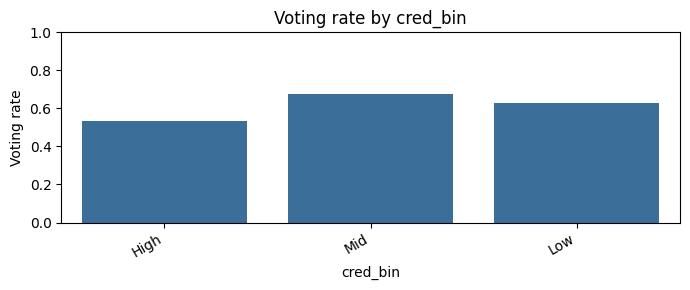

In [11]:
# 수치형 시각화
for col in numeric_features:
    if col in df_feat.columns:
        summary = summarize_numeric(df_feat, col, bins=5)
        plt.figure(figsize=(6, 3))
        sns.barplot(x=summary["bin"].astype(str), y=summary["mean"], color="#2c6faa")
        plt.title(f"Voting rate by {col}")
        plt.xlabel(col)
        plt.ylabel("Voting rate")
        plt.xticks(rotation=30, ha="right")
        plt.ylim(0, 1)
        plt.tight_layout()
        plt.show()

# 범주형 시각화
for col in cat_features:
    if col in df_feat.columns:
        summary = summarize_categorical(df_feat, col)
        plt.figure(figsize=(7, 3))
        sns.barplot(x=summary[col].astype(str), y=summary["mean"], color="#2c6faa")
        plt.title(f"Voting rate by {col}")
        plt.xlabel(col)
        plt.ylabel("Voting rate")
        plt.xticks(rotation=30, ha="right")
        plt.ylim(0, 1)
        plt.tight_layout()
        plt.show()


## 6. 원본 컬럼 기준 비교 (hand / married)
- 01_EDA처럼 원본 카테고리 기준으로 voting rate 확인
- bin 처리로 정보가 사라졌는지 비교


[Raw] hand


,hand,mean,count
1,1,0.545317,39058
2,2,0.540494,4692
3,3,0.592844,1621
0,0,0.633540,161


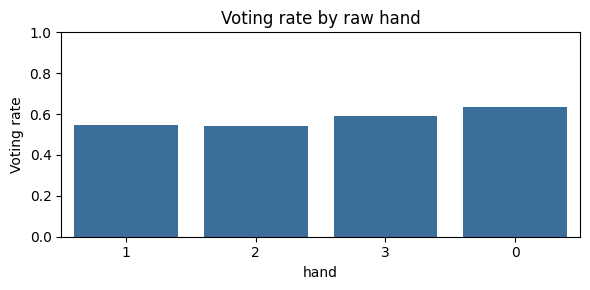

[Raw] married


,married,mean,count
1,1,0.629572,31550
2,2,0.333433,10059
3,3,0.422454,3830
0,0,0.677419,93


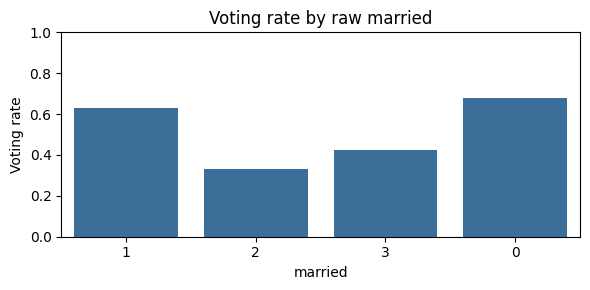

In [13]:
def summarize_raw_categorical(df, col):
    s = df[[col, "voted_bin"]].copy()
    out = s.groupby(col)["voted_bin"].agg(["mean", "count"]).reset_index()
    return out.sort_values("count", ascending=False)

# hand 원본 (0=무응답 포함)
if "hand" in train.columns:
    summary_hand = summarize_raw_categorical(train.assign(voted_bin=(train["voted"]==2).astype(int)), "hand")
    print("[Raw] hand")
    display(summary_hand)
    plt.figure(figsize=(6, 3))
    sns.barplot(x=summary_hand["hand"].astype(str), y=summary_hand["mean"], color="#2c6faa")
    plt.title("Voting rate by raw hand")
    plt.xlabel("hand")
    plt.ylabel("Voting rate")
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

# married 원본 (0=무응답 포함)
if "married" in train.columns:
    summary_married = summarize_raw_categorical(train.assign(voted_bin=(train["voted"]==2).astype(int)), "married")
    print("[Raw] married")
    display(summary_married)
    plt.figure(figsize=(6, 3))
    sns.barplot(x=summary_married["married"].astype(str), y=summary_married["mean"], color="#2c6faa")
    plt.title("Voting rate by raw married")
    plt.xlabel("married")
    plt.ylabel("Voting rate")
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()
